In [3]:
!git clone https://github.com/kad99kev/FGTD.git

'git' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
import sys

sys.path.append('FGTD/scripts')

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.nn import Parameter
from torch.optim.optimizer import Optimizer, required

from dataclasses import dataclass, asdict
import pandas as pd
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
import random

In [9]:
import sys
import os

# Add the directories to the system path
sys.path.append(os.path.abspath("D:/Final Year Project/FGTD/scripts/preprocess"))
sys.path.append(os.path.abspath("D:/Final Year Project/FGTD/scripts/text_encoder"))

from dataset import get_weighted_dataloader
from sentence_encoder import SentenceEncoder
from extract_zip import extract_zip

C:\Users\exam\AppData\Roaming\Python\Python312\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [11]:
def show_grid(img):
    npimg = img.detach().cpu().numpy()  # Ensure it's on CPU before converting to NumPy
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Use 'gray' or 'Greys' for black and white
    plt.axis('off')  # Hide axes
    plt.show()

In [91]:
@dataclass
class Config:
    epochs: int = 20
    batch_size: int = 16
    subset_size: int = 20_000

    noise_size: int = 100
    feature_size: int = 64
    image_size: int = 128
    save_epoch: int = 1
    num_channels: int = 3
    attention: bool = True
    
    embedding_dim: int = 768
    reduced_embedding_dim: int = 256

    g_lr: float = 0.0002
    d_lr: float = 0.0002

    device: 'typing.Any' = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [93]:
import wandb

wandb.init()
cfg = Config()
cfg_dict = asdict(cfg)
# wandb.config.update(cfg_dict)

In [95]:
OUTPUT_DIR = "D:/Final Year Project/archive/img_align_celeba/img_align_celeba"

In [97]:
sentence_encoder = SentenceEncoder(cfg.device)

In [99]:
class ImageNTextDataset(torch.utils.data.Dataset):
    """
    Meant for CelebA Dataset'.
    Pairs True Image, True Text and Wrong Image
    """

    def __init__(self, root_dir, csv_file, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.text_df = pd.read_csv(csv_file)
        self.length = len(self.text_df)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.text_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Real Images
        img_name = os.path.join(self.root_dir, self.text_df.iloc[idx, 0])
        image = Image.open(img_name)

        true_text = random.choice(self.text_df.iloc[idx, 1:].values[0].split('\n')).strip()

        if self.transform:
            true_image = self.transform(image)

        # Wrong Images
        wrong_idx = random.randint(0, self.length - 1)
        while wrong_idx == idx:
            # To get a different index incase it is same
            wrong_idx = random.randint(0, self.length - 1)
        wrong_img_name = os.path.join(self.root_dir, self.text_df.iloc[wrong_idx, 0])
        wrong_image = Image.open(wrong_img_name)

        if self.transform:
            wrong_image = self.transform(wrong_image)

        return true_image, true_text, wrong_image

In [101]:
n_caption_dataset = ImageNTextDataset(
    root_dir=OUTPUT_DIR, 
    csv_file="D:/Final Year Project/filtered_desc.csv",
    transform=transforms.Compose([transforms.Resize((cfg.image_size, cfg.image_size)), transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]),
)

## Create DataLoader

In [104]:
weighted_dataloader, weighted_dataiter = get_weighted_dataloader(
    "D:/Final Year Project/filtered_annotations.csv",  
    custom_dataset=n_caption_dataset,
    batch_size=cfg.batch_size,
    subset_size=cfg.subset_size
)

Length of random indices: 20000
Classes present:  {'Young', 'Chubby', '5_o_Clock_Shadow', 'Big_Nose', 'Mouth_Slightly_Open', 'Receding_Hairline', 'Eyeglasses', 'Blond_Hair', 'Double_Chin', 'Wearing_Necktie', 'Brown_Hair', 'Pale_Skin', 'Attractive', 'Goatee', 'Big_Lips', 'Oval_Face', 'Wearing_Lipstick', 'High_Cheekbones', 'Straight_Hair', 'Bushy_Eyebrows', 'Sideburns', 'Male', 'Black_Hair', 'Heavy_Makeup', 'Mustache', 'Gray_Hair', 'Wearing_Earrings', 'Smiling', 'Narrow_Eyes', 'Rosy_Cheeks', 'Pointy_Nose', 'Wearing_Necklace', 'Wavy_Hair', 'Wearing_Hat', 'Arched_Eyebrows', 'Bald'}
Number of classes:  36
Length of subset dataset: 20000


  0%|          | 0/20000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Using Custom Dataset Loader...


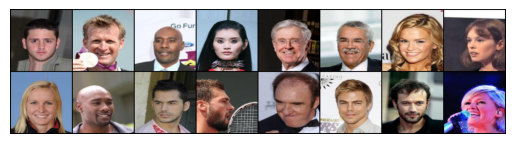

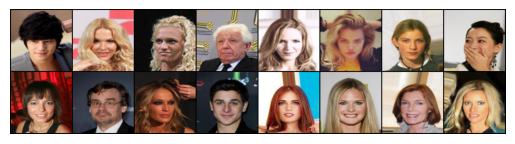

["The gentleman has an oval face. He grows a 5 o' clock shadow. His hair is black and straight. He has bushy eyebrows. He seems young.", 'The man has high cheekbones. He has blond and straight hair. He has a slightly open mouth and a pointy nose. The man is smiling.', 'The gentleman has an oval face. He is bald. He has big lips, a big nose and a slightly open mouth. The gentleman is young and is smiling. He is wearing a necktie.', 'The female has pretty high cheekbones. Her hair is black and straight. She has arched eyebrows and bushy eyebrows. She looks young. She is wearing earrings and lipstick.', 'The male looks chubby, has a double chin and high cheekbones. His hair is gray and straight. He has a big nose and a slightly open mouth. The male is smiling. He is wearing eyeglasses and a necktie.', 'The man has a double chin and an oval face. He grows a mustache. He has straight and receding hair. He has a big nose and a slightly open mouth. The male is smiling. He is wearing eyeglasse

In [106]:
images, labels, wrong_images = next(weighted_dataiter)
show_grid(torchvision.utils.make_grid(images, normalize=True))
show_grid(torchvision.utils.make_grid(wrong_images, normalize=True))
print(labels)

In [108]:
output = sentence_encoder.convert_text_to_embeddings(labels)
print(output)
print(output.shape)

tensor([[ 0.3142, -0.0953,  0.2704,  ...,  0.1521,  0.3152, -0.1101],
        [ 0.3434,  0.2924,  0.4055,  ...,  0.3847,  0.4471, -0.0920],
        [ 0.2729, -0.0426,  0.4065,  ...,  0.5494,  0.3540, -0.1437],
        ...,
        [ 0.4385,  0.1953,  0.1478,  ...,  0.5594,  0.6723, -0.0909],
        [ 0.4202,  0.1781,  0.4227,  ...,  0.0354,  0.3300, -0.1043],
        [ 0.3602, -0.6096,  0.1312,  ..., -0.2877, -0.0804,  0.2267]],
       device='cuda:0')
torch.Size([16, 768])


In [110]:
def initialize_weights(model):
    className = model.__class__.__name__
    if className.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif className.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [112]:
class Self_Attn(nn.Module):
  '''
  Self attention layer
  '''
  def __init__(self, in_dim):
    super().__init__()

    self.query_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim // 2, kernel_size = 1)
    self.key_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim // 2, kernel_size = 1)
    self.value_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim, kernel_size = 1)

    self.gamma = nn.Parameter(torch.zeros(1))
    self.softmax = nn.Softmax(dim = -1)


  def forward(self, x):
    batch_size, C, width, height = x.size()
    query = self.query_conv(x).view(batch_size, -1, width * height).permute(0,2, 1)
    key = self.key_conv(x).view(batch_size, -1, width * height)
    energy = torch.bmm(query, key)

    attn = self.softmax(energy)
    value = self.value_conv(x).view(batch_size, -1, width * height)
    out = torch.bmm(value, attn.permute(0, 2, 1))
    out = out.view(batch_size, C, width, height)

    out = self.gamma * out + x
    return out, attn

In [114]:
def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)

In [116]:
class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

In [118]:
class Generator(nn.Module):
  '''
  Generator architecture
  '''
  def __init__(self, noise_size, embedding_size, reduced_dim_size, num_channels, image_size, attn = True, feature_size = 64):
    super(Generator, self).__init__()
    self.attn = attn
    self.noise_dim = noise_size
    
    assert image_size in [64, 128, 256], "Can only generate images for 64, 128 and 256 dimensions."
    self.image_size = image_size

    ########## Embedding Layer ##########
    self.encode_layer = nn.Sequential(
        nn.Linear(embedding_size, reduced_dim_size),
        nn.BatchNorm1d(reduced_dim_size),
        nn.ReLU(),
        nn.Linear(reduced_dim_size, noise_size),
        nn.BatchNorm1d(noise_size),
        nn.ReLU(),
    )

    # Size 1 -> 4
    self.layer1 = nn.Sequential(
        SpectralNorm(nn.ConvTranspose2d(in_channels = noise_size, out_channels = feature_size*8, kernel_size = 4)),
        nn.BatchNorm2d(feature_size*8),
        nn.ReLU()
    )
    
    # Size 4 -> 8
    self.layer2 = nn.Sequential(
        SpectralNorm(nn.ConvTranspose2d(in_channels = feature_size*8, out_channels = feature_size*4, kernel_size = 4, stride = 2, padding = 1)),
        nn.BatchNorm2d(feature_size*4),
        nn.ReLU()
    )
    
    # Size 8 -> 16
    self.layer3 = nn.Sequential(
        SpectralNorm(nn.ConvTranspose2d(in_channels = feature_size*4, out_channels = feature_size*2, kernel_size = 4, stride = 2, padding = 1)),
        nn.BatchNorm2d(feature_size*2),
        nn.ReLU()
    )

    # Attn1 layer turn 128 dims -> 128 dims
    self.attn1 = Self_Attn(feature_size*2)
    
    # Size 16 -> 32
    self.layer4 = nn.Sequential(
        SpectralNorm(nn.ConvTranspose2d(in_channels = feature_size*2, out_channels = feature_size*2, kernel_size = 4, stride = 2, padding = 1)),
        nn.BatchNorm2d(feature_size*2),
        nn.ReLU()
    )
    
    # Attn2 layer turn 64 dims -> 64 dims
    self.attn2 = Self_Attn(feature_size*2)

    final_size = feature_size * 2
    
    if image_size >= 128:
        # Size 32 -> 64
        self.layer5 = nn.Sequential(
            SpectralNorm(nn.ConvTranspose2d(in_channels = feature_size*2, out_channels = feature_size*2, kernel_size = 4, stride = 2, padding = 1)),
            nn.BatchNorm2d(feature_size*2),
            nn.ReLU()
        )

        final_size = feature_size * 2

        # Attn3 layer turn 64 dims -> 64 dims
        self.attn3 = Self_Attn(feature_size*2)

        if image_size == 256:
            # Size 64 -> 128
            self.layer6 = nn.Sequential(
                SpectralNorm(nn.ConvTranspose2d(in_channels = feature_size*2, out_channels = feature_size, kernel_size = 4, stride = 2, padding = 1)),
                nn.BatchNorm2d(feature_size),
                nn.ReLU()
            )

            final_size = feature_size

        

    # Output last_dim -> last_dim * 2
    self.output_layer = nn.Sequential(
        nn.ConvTranspose2d(final_size, 3, 4, 2, 1),
        nn.Tanh()
    )

    self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.0002, betas = (0.5, 0.999))

  def forward(self, noise, text_embeddings):
    encoded_text = self.encode_layer(text_embeddings)
    # Concatenating the noise and encoded text
    concat_input = torch.mul(noise, encoded_text).view(-1, self.noise_dim, 1, 1)
    
    x = self.layer1(concat_input)
    x = self.layer2(x)
    x = self.layer3(x)
    if self.attn:
      x, _ = self.attn1(x)
    x = self.layer4(x)
    if self.attn:
      x, _ = self.attn2(x)
    if self.image_size >= 128:
        x = self.layer5(x)
        if self.attn:
            x, _ = self.attn3(x)
        if self.image_size == 256:
            x = self.layer6(x)
        

    x = self.output_layer(x)
    return x


In [120]:
generator = Generator(cfg.noise_size, cfg.embedding_dim, cfg.reduced_embedding_dim, cfg.num_channels, cfg.image_size, attn=cfg.attention, feature_size=cfg.feature_size)
generator.cuda()

Generator(
  (encode_layer): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=100, bias=True)
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (layer1): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    )
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2),

torch.Size([16, 3, 128, 128])


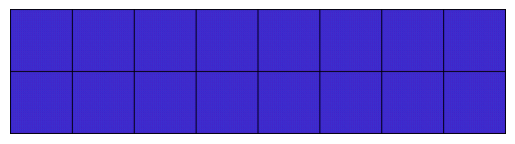

Generator(
  (encode_layer): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=100, bias=True)
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (layer1): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    )
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2),

In [122]:
with torch.no_grad():
  generator.eval()
  noise = torch.randn(size=(cfg.batch_size, cfg.noise_size)).cuda()
  text_embeddings = sentence_encoder.convert_text_to_embeddings(labels)
  output = generator(noise, text_embeddings).detach()
  print(output.shape)
show_grid(torchvision.utils.make_grid(output.cpu(), normalize=True))
generator.train()

In [123]:
class Discriminator(nn.Module):
  '''
  Discriminator architecture
  '''
  def __init__(self, num_channels, feature_size, attn, image_size, embedding_size, reduced_dim_size):
    super(Discriminator, self).__init__()
    self.reduced_dim_size = reduced_dim_size
    self.attn = attn
    self.image_size = image_size

    # Size 256/128/64 -> 128/64/32
    self.layer1 = nn.Sequential(
        SpectralNorm(nn.Conv2d(num_channels, feature_size, 4, 2, 1)),
        nn.LeakyReLU(0.1)
    )
    
    # Size 128/64/32 -> 64/32/16
    self.layer2 = nn.Sequential(
        SpectralNorm(nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1)),
        nn.LeakyReLU(0.1)
    )
    feature_size = feature_size * 2
    
    # Size 64/32/16 -> 32/16/8
    self.layer3 = nn.Sequential(
        SpectralNorm(nn.Conv2d(feature_size , feature_size, 4, 2, 1)),
        nn.LeakyReLU(0.1)
    )
    
    # Attn1 layer remains the same dim and size
    self.attn1 = Self_Attn(feature_size)
    
    # Size 32/16/8 -> 16/8/4
    self.layer4 = nn.Sequential(
        SpectralNorm(nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1)),
        nn.LeakyReLU(0.1)
    )
    feature_size = feature_size * 2
    
    # Attn2 layer remains the same dim and size
    self.attn2 = Self_Attn(feature_size)

    if image_size >= 128:
        # Size 16/8 -> 8/4
        self.layer5 = nn.Sequential(
            SpectralNorm(nn.Conv2d(feature_size, feature_size, 4, 2, 1)),
            nn.LeakyReLU(0.1)
        )

        self.attn3 = Self_Attn(feature_size)

        if image_size == 256:
            # Size 8 -> 4

            self.layer6 = nn.Sequential(
                SpectralNorm(nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1)),
                nn.LeakyReLU(0.1)
            )
            
            feature_size = feature_size * 2

    ########## Text Encode ##########
    self.encode_text = nn.Sequential(
        nn.Linear(embedding_size, reduced_dim_size),
        nn.LeakyReLU(0.2, inplace=True)
    )

    ########## Text + Image Concate Layer ##########
    self.image_text_layer = nn.Sequential(
        nn.Conv2d(feature_size + reduced_dim_size, feature_size * 8, 1, 1, 0, bias=False),
        nn.BatchNorm2d(feature_size * 8),
        nn.LeakyReLU(0.2,inplace=True),
    )

    ########## Output Layer ##########
    self.output_layer = nn.Sequential(
        nn.Conv2d(feature_size * 8, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )

    self.optimizer = optim.Adam(self.parameters(), lr=0.0002, betas=(0.5, 0.999))

  def forward(self, input_images, text_embeddings):
    x = self.layer1(input_images)
    x = self.layer2(x)
    x = self.layer3(x)
    if self.attn:
      x, _ = self.attn1(x)
    x = self.layer4(x)
    if self.attn:
      x, _ = self.attn2(x)
    if self.image_size >= 128:
        x = self.layer5(x)
        if self.attn:
            x, _ = self.attn3(x)
        if self.image_size == 256:
            x = self.layer6(x)

    ## Text ##
    encoded_text = self.encode_text(text_embeddings)
    encoded_text = encoded_text.unsqueeze(2).unsqueeze(2).repeat(1, 1, 4, 4)

    ## Text + Image ##
    concat_output = self.image_text_layer(torch.cat([x, encoded_text], dim=1))
    output = self.output_layer(concat_output)

    return output.view(-1, 1)


In [126]:
discriminator = Discriminator(cfg.num_channels, cfg.image_size, cfg.attention, cfg.image_size, cfg.embedding_dim, cfg.reduced_embedding_dim)
discriminator.cuda()

Discriminator(
  (layer1): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  (layer2): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  (layer3): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  (attn1): Self_Attn(
    (query_conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (value_conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=-1)
  )
  (layer4): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  

In [128]:
with torch.no_grad():
  discriminator.eval()
  validity = discriminator(output, text_embeddings)
  print(validity.shape)
discriminator.train()

torch.Size([16, 1])


Discriminator(
  (layer1): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  (layer2): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  (layer3): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  (attn1): Self_Attn(
    (query_conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (value_conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=-1)
  )
  (layer4): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  

In [130]:
plt_images, plt_labels, plt_wrong = next(weighted_dataiter)
plt_o_text_embeddings = sentence_encoder.convert_text_to_embeddings(plt_labels)
plt_o_text_embeddings.shape

torch.Size([16, 768])

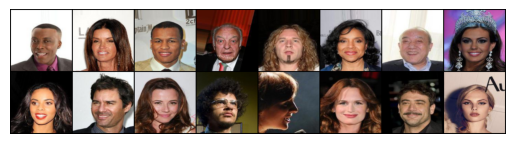

['The gentleman looks chubby, has a double chin and pretty high cheekbones. His hair is black and receding. He has big lips, a big nose and a slightly open mouth. The male is smiling. He is wearing earrings and a necktie.', 'The woman has pretty high cheekbones. Her hair is straight. She has big lips, a big nose and a slightly open mouth. The female looks young and is smiling. She is wearing earrings and lipstick.', 'The gentleman has pretty high cheekbones. He has black hair. He has big lips, a big nose and a slightly open mouth. He is smiling and seems young. He is wearing a necktie.', 'The male has a chubby face and has a double chin. He has gray and receding hair. He has a big nose, bushy eyebrows and a slightly open mouth. He is wearing a necktie.', 'The gentleman is chubby. He grows a goatee.', 'The woman has high cheekbones. Her hair is black and wavy. She has arched eyebrows, big lips, a big nose and a slightly open mouth. The female is smiling and has heavy makeup. She is wear

In [132]:
show_grid(torchvision.utils.make_grid(plt_images.cpu(), normalize=True))
print(plt_labels)

In [134]:
fixed_noise = torch.randn(size=(len(plt_labels), cfg.noise_size)).cuda()

In [136]:
def plot_output(epoch):
  plt.clf()
  with torch.no_grad():

    generator.eval()
    test_images = generator(fixed_noise, plt_o_text_embeddings)
    generator.train()
    grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
    show_grid(grid)
  
  wandb.log({'output': wandb.Image(grid, caption=f'Output for epoch: {epoch}')}, step=epoch)

In [138]:
adversarial_loss = nn.BCELoss().cuda()

In [140]:


# Compare this weights with the discriminator defined below 
discriminator.state_dict()

OrderedDict([('layer1.0.module.bias',
              tensor([ 0.1217,  0.0957,  0.0007,  0.0940,  0.1357, -0.0564, -0.1129,  0.0644,
                      -0.0217, -0.0169,  0.0842, -0.0512,  0.0656,  0.0406,  0.1047,  0.1030,
                       0.1085, -0.1292,  0.0091,  0.1071,  0.0233,  0.0939,  0.0531, -0.0086,
                       0.1072,  0.0748, -0.1178,  0.0034,  0.0659,  0.0181, -0.1406,  0.0185,
                      -0.0756,  0.0967,  0.0916,  0.0605, -0.0437,  0.0560, -0.0819,  0.0626,
                       0.0669, -0.0191,  0.0303, -0.1087, -0.0700, -0.1421, -0.1412, -0.0318,
                       0.1276,  0.0003,  0.1220, -0.0107,  0.0924,  0.1322,  0.1152,  0.0068,
                      -0.1087, -0.0125,  0.0979, -0.0686,  0.1142, -0.0601,  0.0197,  0.0531,
                      -0.0712, -0.0225, -0.0397,  0.0523,  0.0484, -0.0219, -0.0667,  0.1201,
                       0.0577,  0.0090, -0.0831,  0.0060,  0.1048, -0.0912,  0.0255,  0.0166,
                      

In [141]:
# Compare this weights with the generator defined below 
generator.state_dict()

OrderedDict([('encode_layer.0.weight',
              tensor([[-0.0169, -0.0238, -0.0160,  ..., -0.0317, -0.0063,  0.0228],
                      [ 0.0313, -0.0174,  0.0128,  ..., -0.0129, -0.0200, -0.0049],
                      [-0.0282, -0.0206, -0.0235,  ...,  0.0231, -0.0340,  0.0057],
                      ...,
                      [ 0.0147,  0.0147,  0.0113,  ...,  0.0315, -0.0193, -0.0260],
                      [ 0.0302,  0.0062, -0.0198,  ...,  0.0299,  0.0082,  0.0226],
                      [ 0.0181, -0.0004, -0.0323,  ..., -0.0162,  0.0323, -0.0226]],
                     device='cuda:0')),
             ('encode_layer.0.bias',
              tensor([ 0.0094, -0.0207,  0.0333, -0.0034, -0.0127, -0.0136,  0.0023, -0.0034,
                      -0.0086,  0.0331, -0.0036,  0.0211, -0.0167,  0.0095,  0.0185,  0.0034,
                      -0.0178,  0.0100,  0.0047, -0.0025, -0.0254, -0.0046, -0.0032, -0.0158,
                      -0.0306, -0.0357,  0.0212, -0.0045,  0.0029,  0.

In [144]:
discriminator = Discriminator(cfg.num_channels, cfg.image_size, cfg.attention, cfg.image_size, cfg.embedding_dim, cfg.reduced_embedding_dim)
discriminator.load_state_dict(torch.load("discriminator.pt", weights_only=True))

discriminator.state_dict()

OrderedDict([('layer1.0.module.bias',
              tensor([ 8.7826e-03, -2.0977e-03, -5.6304e-02, -3.7210e-03, -6.4795e-03,
                      -7.9906e-02, -1.1404e-02, -4.1458e-02, -1.3124e-01, -2.8338e-03,
                      -1.0433e-02,  1.2863e-04, -8.2437e-03, -3.8682e-02, -4.7260e-02,
                      -7.9112e-02, -4.2099e-03, -9.4142e-02, -2.1192e-01, -4.5055e-02,
                      -6.4200e-02, -1.1358e-01, -1.0710e-01, -5.0217e-03, -3.4817e-02,
                      -2.6973e-03, -2.5874e-03,  3.7773e-03, -8.4053e-03, -4.1094e-03,
                      -7.9754e-03, -1.0571e-02, -3.6926e-02, -9.7750e-04, -4.4045e-03,
                      -1.8689e-01, -6.1719e-04, -1.1747e-02, -2.6136e-01, -4.0682e-03,
                      -8.2278e-03, -3.1097e-02, -1.5551e-01, -8.1652e-03, -4.5126e-03,
                      -3.2173e-03, -1.1791e-03, -1.3505e-02,  1.9422e-02, -1.1817e-02,
                      -1.5483e-02, -2.7684e-02, -3.3081e-03, -3.1466e-03, -1.0537e-01,
     

In [146]:
generator = Generator(cfg.noise_size, cfg.embedding_dim, cfg.reduced_embedding_dim, cfg.num_channels, cfg.image_size, attn=cfg.attention, feature_size=cfg.feature_size)
generator.load_state_dict(torch.load("generator.pt", weights_only=True))

generator.state_dict()
generator.cuda()
discriminator.cuda()

Discriminator(
  (layer1): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  (layer2): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  (layer3): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  (attn1): Self_Attn(
    (query_conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (value_conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=-1)
  )
  (layer4): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  

In [ ]:
#This skip for now only for training epochs run again
pbar = tqdm()

# Add models to wandb
wandb.watch(generator)
wandb.watch(discriminator)

for epoch in range(cfg.epochs):
    print(f'Epoch: {epoch + 1} / {cfg.epochs}')
    pbar.reset(total=len(weighted_dataloader))

    # Setting up losses
    discriminator_losses = []
    generator_losses = []

    for i, (real_images, real_text, wrong_images) in enumerate(weighted_dataloader):

        # Current batch size
        current_batch_size = real_images.size()[0]

        # Convert to cuda
        real_images = real_images.cuda()
        wrong_images = wrong_images.cuda()
        text_embeddings = sentence_encoder.convert_text_to_embeddings(real_text)

        # For real vs fake
        real_validity = torch.ones(current_batch_size, 1).cuda()
        fake_validity = torch.zeros(current_batch_size, 1).cuda()

        # Train Generator
        generator.zero_grad()
        input_noise = torch.randn(size=(current_batch_size, cfg.noise_size)).cuda()
        fake_images = generator(input_noise, text_embeddings)
        discriminator_fake_validity = discriminator(fake_images, text_embeddings)
        generator_loss = adversarial_loss(discriminator_fake_validity, real_validity)

        generator_loss.backward()
        generator.optimizer.step()
        generator_losses.append(generator_loss)

        # Train Discriminator
        discriminator.zero_grad()

        ## To calculate real loss
        discriminator_real_validity = discriminator(real_images, text_embeddings)
        discriminator_real_loss = adversarial_loss(discriminator_real_validity, real_validity)

        ## To calculate wrong loss
        discriminator_wrong_validity = discriminator(wrong_images, text_embeddings)
        discriminator_wrong_loss = adversarial_loss(discriminator_wrong_validity, fake_validity)

        ## To calculate fake loss
        discriminator_fake_validity = discriminator(fake_images.detach(), text_embeddings)
        discriminator_fake_loss = adversarial_loss(discriminator_fake_validity, fake_validity)

        ## Calculating total loss
        discriminator_loss = discriminator_real_loss + discriminator_wrong_loss + discriminator_fake_loss
        discriminator_loss.backward()
        discriminator.optimizer.step()
        discriminator_losses.append(discriminator_loss)


        # Update tqdm
        pbar.update()

    print('Discriminator Loss: {:.3f}, Generator Loss: {:.3f}'.format(
            torch.mean(torch.FloatTensor(discriminator_losses)),
            torch.mean(torch.FloatTensor(generator_losses))
    ))
    
    wandb.log({"generator loss" : torch.mean(torch.FloatTensor(generator_losses)), "discriminator loss" : torch.mean(torch.FloatTensor(discriminator_losses))}, step=epoch+1)
    
    if (epoch + 1) % cfg.save_epoch == 0:
        plot_output(epoch+1)

pbar.refresh()

0it [00:00, ?it/s]

Epoch: 1 / 20


In [69]:
# run the save only if you train
torch.save(discriminator.state_dict(),"discriminator.pt")

In [71]:
torch.save(generator.state_dict(),"generator.pt")

In [73]:
d = Discriminator(cfg.num_channels, cfg.image_size, cfg.attention, cfg.image_size, cfg.embedding_dim, cfg.reduced_embedding_dim)
d.load_state_dict(torch.load("discriminator.pt", weights_only=True))

d.state_dict()

OrderedDict([('layer1.0.module.bias',
              tensor([ 8.7826e-03, -2.0977e-03, -5.6304e-02, -3.7210e-03, -6.4795e-03,
                      -7.9906e-02, -1.1404e-02, -4.1458e-02, -1.3124e-01, -2.8338e-03,
                      -1.0433e-02,  1.2863e-04, -8.2437e-03, -3.8682e-02, -4.7260e-02,
                      -7.9112e-02, -4.2099e-03, -9.4142e-02, -2.1192e-01, -4.5055e-02,
                      -6.4200e-02, -1.1358e-01, -1.0710e-01, -5.0217e-03, -3.4817e-02,
                      -2.6973e-03, -2.5874e-03,  3.7773e-03, -8.4053e-03, -4.1094e-03,
                      -7.9754e-03, -1.0571e-02, -3.6926e-02, -9.7750e-04, -4.4045e-03,
                      -1.8689e-01, -6.1719e-04, -1.1747e-02, -2.6136e-01, -4.0682e-03,
                      -8.2278e-03, -3.1097e-02, -1.5551e-01, -8.1652e-03, -4.5126e-03,
                      -3.2173e-03, -1.1791e-03, -1.3505e-02,  1.9422e-02, -1.1817e-02,
                      -1.5483e-02, -2.7684e-02, -3.3081e-03, -3.1466e-03, -1.0537e-01,
     

In [75]:
generator.state_dict()

OrderedDict([('encode_layer.0.weight',
              tensor([[-0.0737, -0.0111, -0.0071,  ..., -0.0560, -0.0532,  0.0407],
                      [-0.0578,  0.0215,  0.0216,  ...,  0.0264,  0.0072, -0.0539],
                      [ 0.1373,  0.0148,  0.0297,  ...,  0.0028,  0.0028,  0.0532],
                      ...,
                      [-0.1336,  0.0294,  0.0948,  ..., -0.0276,  0.0085, -0.0304],
                      [-0.0150, -0.0196,  0.0141,  ..., -0.0077, -0.0284,  0.0893],
                      [-0.0164,  0.0243, -0.0273,  ..., -0.0144,  0.0656,  0.0679]],
                     device='cuda:0')),
             ('encode_layer.0.bias',
              tensor([-2.8441e-02, -4.3030e-02, -3.3224e-02, -6.6533e-03,  7.6127e-02,
                       6.0405e-03, -5.1359e-02, -2.5230e-02,  4.1292e-02, -5.4938e-02,
                      -4.5542e-03, -3.9977e-03, -2.2388e-02,  7.6945e-03,  7.1354e-02,
                      -2.9340e-02,  4.1042e-02,  9.3913e-03, -3.6687e-02,  3.7139e-02,
    

In [76]:
g = Generator(cfg.noise_size, cfg.embedding_dim, cfg.reduced_embedding_dim, cfg.num_channels, cfg.image_size, attn=cfg.attention, feature_size=cfg.feature_size)
g.load_state_dict(torch.load("generator.pt", weights_only=True))

g.state_dict()

OrderedDict([('encode_layer.0.weight',
              tensor([[-0.0737, -0.0111, -0.0071,  ..., -0.0560, -0.0532,  0.0407],
                      [-0.0578,  0.0215,  0.0216,  ...,  0.0264,  0.0072, -0.0539],
                      [ 0.1373,  0.0148,  0.0297,  ...,  0.0028,  0.0028,  0.0532],
                      ...,
                      [-0.1336,  0.0294,  0.0948,  ..., -0.0276,  0.0085, -0.0304],
                      [-0.0150, -0.0196,  0.0141,  ..., -0.0077, -0.0284,  0.0893],
                      [-0.0164,  0.0243, -0.0273,  ..., -0.0144,  0.0656,  0.0679]])),
             ('encode_layer.0.bias',
              tensor([-2.8441e-02, -4.3030e-02, -3.3224e-02, -6.6533e-03,  7.6127e-02,
                       6.0405e-03, -5.1359e-02, -2.5230e-02,  4.1292e-02, -5.4938e-02,
                      -4.5542e-03, -3.9977e-03, -2.2388e-02,  7.6945e-03,  7.1354e-02,
                      -2.9340e-02,  4.1042e-02,  9.3913e-03, -3.6687e-02,  3.7139e-02,
                      -2.6084e-02,  5.3948

In [79]:
g = g.cuda()
# 
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['She has arched eyebrows, a slightly  open mouth and a pointy nose. She has brown and straight hair. The lady has pretty high cheekbones. She is wearing earrings and lipstick. The lady is attractive, young, smiling and is wearing heavy makeup '])

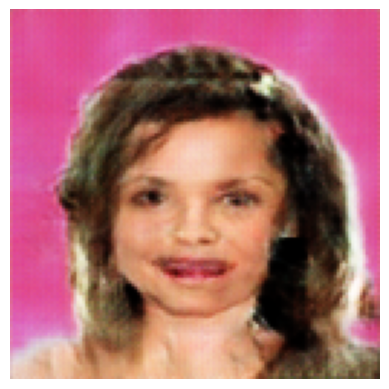

In [81]:
g.eval()
test_image = g(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

In [152]:
g = g.cuda()
# 
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings([''])

## Using DCGAN

In [120]:
import pandas as pd
import os
import shutil

# Paths
images_path = 'D:/Final Year Project/archive/img_align_celeba/img_align_celeba'  # Adjust this path to your images directory
annotations_path = 'D:/Final Year Project/FGTD/dataset/list_attr_celeba.csv'  # Adjust this path to your annotations file
output_images_path = 'D:/Final Year Project/filtered_image'  # Directory to save filtered images
output_annotations_path = "D:/Final Year Project/filtered_annotations.csv" 
descriptions_path = "D:/Final Year Project/FGTD/dataset/text_descr_celeba.csv"  # Ensure this path is correct
output_descriptions_path = "D:/Final Year Project/filtered_desc.csv"  # File to save filtered descriptions

# Create output directory if it doesn't exist
os.makedirs(output_images_path, exist_ok=True)

# Load annotations
annotations = pd.read_csv(annotations_path)

# Check if the dataset has at least 50,000 entries
if len(annotations) < 50000:
    raise ValueError("The dataset has fewer than 50,000 entries.")

# Filter to keep only the first 50,000 entries
filtered_annotations = annotations.iloc[:50000]

# Save the filtered annotations
filtered_annotations.to_csv(output_annotations_path, index=False)

# Copy the corresponding images
for img_name in filtered_annotations['image_id']:  # Adjust 'image_id' to your column name
    shutil.copy(os.path.join(images_path, img_name), output_images_path)

print(f"Filtered dataset saved: {len(filtered_annotations)} images and descriptions.")

# Read descriptions
with open(descriptions_path, 'r') as desc_file:
    all_descriptions = desc_file.readlines()

# Ensure that we have enough descriptions
if len(all_descriptions) < 50000:
    raise ValueError("The descriptions file has fewer than 50,000 entries.")

# Get the first 50,000 descriptions
filtered_descriptions = all_descriptions[:50000]

# Save the filtered descriptions to a new file
with open(output_descriptions_path, 'w') as out_desc_file:
    out_desc_file.writelines(filtered_descriptions)

print(f"Filtered descriptions saved: {len(filtered_descriptions)} descriptions.")


Filtered dataset saved: 50000 images and descriptions.
Filtered descriptions saved: 50000 descriptions.


In [118]:
import pandas as pd

# Specify the path to your desktop
desktop_path = 'D:/Final Year Project/filtered_desc.csv'  # Change 'YourUsername' accordingly

# Create an empty DataFrame
empty_df = pd.DataFrame()

# Save the empty DataFrame to a CSV file
empty_df.to_csv(desktop_path, index=False)

print(f"Empty CSV file created at: {desktop_path}")


Empty CSV file created at: D:/Final Year Project/filtered_desc.csv


In [122]:
import wandb
wandb.init(project="text-to-face", name="dcgan")

In [124]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
from tqdm.notebook import tqdm
from dataclasses import asdict, dataclass

In [126]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [128]:
from transformers import DistilBertTokenizer, DistilBertModel, BertTokenizer, BertModel

In [130]:
@dataclass
class Config:
  epochs: int = 20
  image_size: int = 128
  initial_size: int = 64
  noise_size: int = 100
  batch_size: int = 64
  subset_size: int = 20_000
  num_channels: int = 3

  device: 'typing.Any' = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [132]:
cfg = Config()
cfg_dict = asdict(cfg)
wandb.config.update(cfg_dict)

In [134]:
sentence_encoder = SentenceEncoder(cfg.device)

In [135]:
def show_grid(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

In [138]:
weighted_dataloader, weighted_dataiter = get_weighted_dataloader(
    "D:/Final Year Project/filtered_annotations.csv",  
    image_location="D:/Final Year Project/filtered_image",
    text_desc_location="D:/Final Year Project/filtered_desc.csv",
    transform=transforms.Compose([transforms.Resize((cfg.image_size, cfg.image_size)), transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]),
    batch_size=cfg.batch_size,
    subset_size=cfg.subset_size
)

Length of random indices: 20000
Classes present:  {'Goatee', 'Wearing_Necklace', 'Heavy_Makeup', 'Rosy_Cheeks', 'Smiling', 'Wearing_Earrings', 'Big_Nose', 'Bald', 'Sideburns', 'Young', 'Oval_Face', 'Wavy_Hair', 'Bushy_Eyebrows', 'Wearing_Hat', 'Narrow_Eyes', 'Pointy_Nose', 'Mustache', '5_o_Clock_Shadow', 'Mouth_Slightly_Open', 'Wearing_Necktie', 'Pale_Skin', 'Double_Chin', 'Gray_Hair', 'Wearing_Lipstick', 'Receding_Hairline', 'Straight_Hair', 'Eyeglasses', 'Chubby', 'Blond_Hair', 'Attractive', 'Brown_Hair', 'Male', 'Arched_Eyebrows', 'High_Cheekbones', 'Black_Hair', 'Big_Lips'}
Number of classes:  36
Length of subset dataset: 20000


  0%|          | 0/20000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Using ImageTextDataset loader...


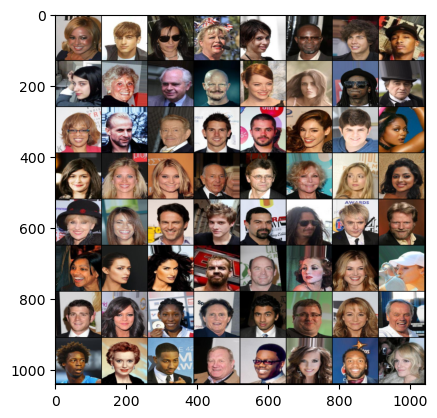

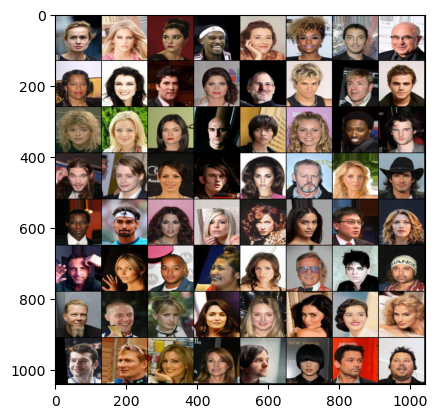

['The female has high cheekbones. Her hair is wavy. She has arched eyebrows, big lips, a slightly open mouth and narrow eyes. She seems young, is smiling, has rosy cheeks and heavy makeup. She is wearing earrings, lipstick and a necklace.', 'The gentleman has high cheekbones and an oval face. His hair is straight. He has bushy eyebrows. The gentleman looks young.', 'Her hair is black. She has big lips. The woman looks young. She is wearing eyeglasses, earrings, lipstick and a necklace.', 'The woman has pretty high cheekbones. Her hair is wavy. She has a slightly open mouth. The female is smiling and has heavy makeup. She is wearing lipstick.', 'She has arched eyebrows, big lips, a big nose and a slightly open mouth. She is smiling, is attractive, young and has heavy makeup.', 'The gentleman is chubby, has a double chin and pretty high cheekbones. He wears a goatee. He has big lips, a big nose and a slightly open mouth. The male is smiling. He is wearing eyeglasses.', 'The male has high

In [140]:
images, labels, wrong_images = next(weighted_dataiter)
show_grid(torchvision.utils.make_grid(images, normalize=True))
show_grid(torchvision.utils.make_grid(wrong_images, normalize=True))
print(labels)

In [141]:
def initialize_weights(model):
    className = model.__class__.__name__
    if className.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif className.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [142]:
class Generator(nn.Module):
    '''
    The Generator Network
    '''

    def __init__(self, noise_size, feature_size, num_channels, embedding_size, reduced_dim_size):
        super(Generator, self).__init__()
        self.reduced_dim_size = reduced_dim_size

        self.projection = nn.Sequential(
            nn.Linear(in_features = embedding_size, out_features = reduced_dim_size),
            nn.BatchNorm1d(num_features = reduced_dim_size),
            nn.LeakyReLU(negative_slope = 0.2, inplace = True)
        )

        self.layer = nn.Sequential(
            nn.ConvTranspose2d(noise_size + reduced_dim_size, feature_size * 8, 4, 1, 0, bias = False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(negative_slope = 0.2, inplace = True),

            # state size (ngf*4) x 4 x 4
            nn.ConvTranspose2d(feature_size * 8, feature_size * 4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(feature_size * 4),
            nn.ReLU(True),

            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(feature_size * 4, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.ReLU(True),

            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(feature_size * 2, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),

            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(feature_size, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),

            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(feature_size, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()

        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.0002, betas = (0.5, 0.5))

    def forward(self, noise, text_embeddings):
        encoded_text = self.projection(text_embeddings)
        concat_input = torch.cat([noise, encoded_text], dim = 1).unsqueeze(2).unsqueeze(2)
        output = self.layer(concat_input)
        return output

In [146]:
generator = Generator(cfg.noise_size, cfg.image_size, cfg.num_channels, 768, 256)
generator.apply(initialize_weights)
generator.cuda()

Generator(
  (projection): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer): Sequential(
    (0): ConvTranspose2d(356, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2),

torch.Size([64, 3, 128, 128])


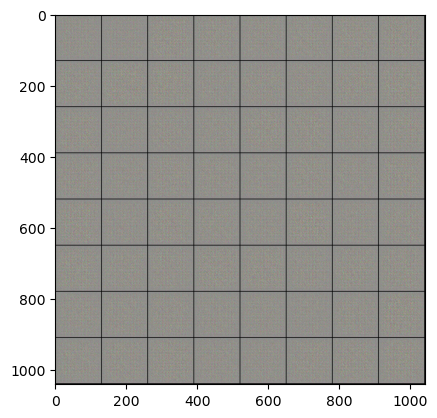

Generator(
  (projection): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer): Sequential(
    (0): ConvTranspose2d(356, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2),

In [148]:
with torch.no_grad():
  generator.eval()
  noise = torch.randn(size=(cfg.batch_size, cfg.noise_size)).cuda()
  text_embeddings = sentence_encoder.convert_text_to_embeddings(labels)
  output = generator(noise, text_embeddings).detach()
  print(output.shape)
show_grid(torchvision.utils.make_grid(output.cpu(), normalize=True))
generator.train()

In [149]:
class Discriminator(nn.Module):
    '''
    The Discriminator Network
    '''

    def __init__(self, num_channels, feature_size, embedding_size, reduced_dim_size):
        super(Discriminator, self).__init__()
        self.reduced_dim_size = reduced_dim_size

        ## Image Encoder 
        self.netD_1 = nn.Sequential(
            # input nc x 128 x 128
            nn.Conv2d(num_channels, feature_size, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),

            # input nc x 64 x 64
            nn.Conv2d(feature_size, feature_size, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),

            # state size ndf x 32 x 32
            nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(feature_size * 2),
            nn.LeakyReLU(0.2, inplace = True),

            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(feature_size * 2, feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(feature_size * 4, feature_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(0.2, inplace=True),

        )

        ## Text Encoder
        self.projector = nn.Sequential(
            nn.Linear(in_features=embedding_size, out_features=reduced_dim_size),
            nn.BatchNorm1d(num_features=reduced_dim_size),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        ## Text + Image Concat Layer
        self.netD_2 = nn.Sequential(
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(feature_size * 8 + reduced_dim_size, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.0001, betas = (0.5, 0.5))

    def forward(self, input_img, text_embeddings):
        x_intermediate = self.netD_1(input_img)
        
        projected_embed = self.projector(text_embeddings)
        
        replicated_embed = projected_embed.repeat(4, 4, 1, 1).permute(2,  3, 0, 1)
        hidden_concat = torch.cat([x_intermediate, replicated_embed], 1)
        
        x = self.netD_2(hidden_concat)

        return x.view(-1, 1), x_intermediate

In [152]:
discriminator = Discriminator(cfg.num_channels, cfg.image_size, 768, 256)
discriminator.apply(initialize_weights)
discriminator.cuda()

Discriminator(
  (netD_1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slo

In [154]:
with torch.no_grad():
  discriminator.eval()
  validity, _ = discriminator(output, text_embeddings)
  print(validity.shape)
discriminator.train()

torch.Size([64, 1])


Discriminator(
  (netD_1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slo

In [156]:
criterion = nn.BCELoss().cuda()
l2_loss = nn.MSELoss().cuda()
l1_loss = nn.L1Loss().cuda()

In [158]:
plt_images, plt_labels, plt_wrong = next(weighted_dataiter)
plt_o_text_embeddings = sentence_encoder.convert_text_to_embeddings(plt_labels)
plt_o_text_embeddings.shape

torch.Size([64, 768])

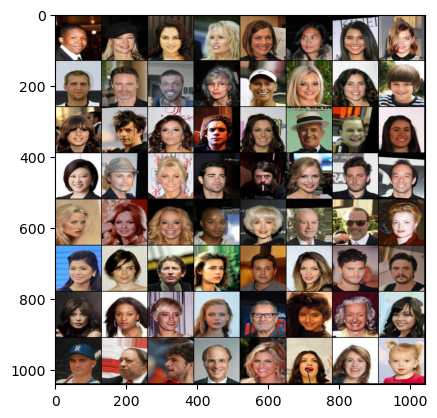

['The gentleman is chubby, has pretty high cheekbones and an oval face. He has big lips and a big nose. The man is smiling and is young. He is wearing a necktie.', 'The woman has high cheekbones. She has a big nose and a slightly open mouth. She is smiling, is attractive, has rosy cheeks and heavy makeup. She is wearing earrings, a hat, lipstick and a necklace.', 'The lady has pretty high cheekbones. She has brownish black and wavy hair. She has a slightly open mouth. The lady looks attractive, young, is smiling and has heavy makeup. She is wearing earrings and lipstick.', 'The female has high cheekbones. Her hair is blond and wavy. She has a slightly open mouth and a pointy nose. She is smiling, has heavy makeup and pale skin. She is wearing lipstick.', 'The female has pretty high cheekbones. She has straight hair. She has arched eyebrows, big lips, a slightly open mouth and narrow eyes. The female is smiling. She is wearing earrings and lipstick.', 'She has black and wavy hair. She h

In [159]:
show_grid(torchvision.utils.make_grid(plt_images.cpu(), normalize=True))
print(plt_labels)

In [160]:
fixed_noise = torch.randn(size=(len(plt_labels), cfg.noise_size)).cuda()

In [162]:
def plot_output(epoch):
  plt.clf()
  with torch.no_grad():

    generator.eval()
    test_images = generator(fixed_noise, plt_o_text_embeddings)
    generator.train()
  
    grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
    show_grid(grid)

  wandb.log({'output': wandb.Image(grid, caption=f'Output for epoch: {epoch}')}, step=epoch)

In [166]:
discriminator.load_state_dict(torch.load("dhanush.pt", weights_only=True))

discriminator.state_dict()
discriminator.cuda()
discriminator.cuda()

Discriminator(
  (netD_1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slo

In [168]:
generator.load_state_dict(torch.load("dh1.pt", weights_only=True))

generator.state_dict()
generator.cuda()
discriminator.cuda()

Discriminator(
  (netD_1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slo

In [ ]:
pbar = tqdm()

wandb.watch(generator)
wandb.watch(discriminator)

for epoch in range(cfg.epochs):
    print(f'Epoch:  {epoch + 1} / {cfg.epochs}')
    pbar.reset(total = len(weighted_dataloader))

    discriminator_loss = []
    generator_loss = []

    for i, (real_images, real_text, wrong_images) in enumerate(weighted_dataloader):
        current_batch_size = real_images.size()[0]

        #converting to cuda
        real_images = real_images.cuda()
        text_embeddings = sentence_encoder.convert_text_to_embeddings(real_text)
        wrong_images = wrong_images.cuda()

        real_validity = torch.ones(current_batch_size, 1).cuda()
        fake_validity = torch.zeros(current_batch_size, 1).cuda()

        temp_tensor = (torch.ones(current_batch_size, 1).cuda()) * (-0.1)    
        smoothed_real_labels = torch.add(real_validity, temp_tensor)

        ## Training the discriminator
        discriminator.zero_grad()
        output, activation_real = discriminator(real_images, text_embeddings)
        real_loss = criterion(output, smoothed_real_labels)
        real_score = output

        output, _ = discriminator(wrong_images, text_embeddings)
        wrong_loss = criterion(output, fake_validity)

        input_noise = torch.randn(size=(current_batch_size, cfg.noise_size)).cuda()
        fake_images = generator(input_noise, text_embeddings)
        output, _ = discriminator(fake_images, text_embeddings)
        fake_loss = criterion(output, fake_validity)

        d_loss = real_loss + wrong_loss + fake_loss

        d_loss.backward()
        discriminator.optimizer.step()
        discriminator_loss.append(d_loss)

        ## Training generator
        generator.zero_grad()
        input_noise = torch.randn(size=(current_batch_size, cfg.noise_size)).cuda()
        fake_images = generator(input_noise, text_embeddings)
        output, activation_fake = discriminator(fake_images, text_embeddings)
        _, activation_real = discriminator(real_images, text_embeddings)

        activation_fake = torch.mean(activation_fake, 0)    #try with median and check if it converges
        activation_real = torch.mean(activation_real, 0)    #try with median and check if it converges

        g_loss = criterion(output, real_validity) + 100 * l2_loss(activation_fake, activation_real.detach()) + 50 * l1_loss(fake_images, real_images)

        g_loss.backward()
        generator.optimizer.step()
        generator_loss.append(g_loss)

        pbar.update()

    print('Discriminator Loss: {:.3f}, Generator Loss: {:.3f}'.format(
          torch.mean(torch.FloatTensor(discriminator_loss)),
          torch.mean(torch.FloatTensor(generator_loss))

  ))
  
    wandb.log({"generator loss" : torch.mean(torch.FloatTensor(generator_loss)), "discriminator loss" : torch.mean(torch.FloatTensor(discriminator_loss))}, step=epoch+1)

    if (epoch + 1) % 1 == 0:
      plot_output(epoch + 1)

pbar.refresh()

In [170]:
torch.save(discriminator.state_dict(),"dhanush.pt")

In [172]:
torch.save(generator.state_dict(),"dh1.pt")

In [328]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(["A woman has high cheekbones and chubby cheek and fair skin and curly hair, she is wearing lipstick."])

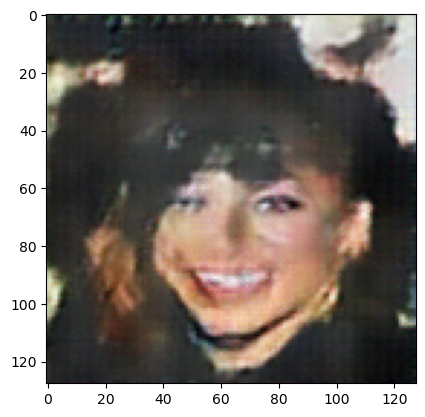

In [330]:
generator.eval()
test_image = generator(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

In [312]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(["A black man having grey hair,oval face"])

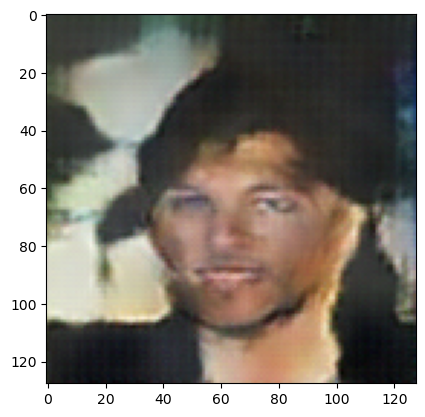

In [313]:
generator.eval()
test_image = generator(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))